In [ ]:
### Deze dataset is GEEN onderdeel van de pipeline, maar is een oefening voor een aantal functies die gebruikt worden om de dataset samen te stellen en daar stastistieken uit te halen. ###
### This dataset is NOT a part of the pipeline. It's practice code that includes some functions that will be used to compile the dataset and use it to extract statistics. ###

In [15]:
# import benodigde packages
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers as ppb
from numpy import random

In [16]:
# laad een model voor sentiment analysis
# load a model to do sentiment analysis later
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("wietsedv/bert-base-dutch-cased-finetuned-sentiment")
model = AutoModel.from_pretrained("wietsedv/bert-base-dutch-cased-finetuned-sentiment") 

Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased-finetuned-sentiment were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# inladen data
# load datasets
dataset_path = "~/share/Milena/programma-discriminatie-en-racisme/datasets/"
dataset = pd.read_csv(dataset_path + 'dataset_milena.csv', sep = ';') # voor dummy dataset importeer eerste paar instances / for dummy dataset only import first few instances

# lege regels droppen
# drop empty lines
dataset = dataset.dropna(subset=['text'])

In [18]:
# als je maar een deel van de dataset wil testen, zet filter = True
# if you only want to test this for part of the dataset, set filter = True
filter = False

if filter == True:
    # filter de eerste 100 of zo zinnen eruit met een woord erin
    # filter out the first 100 or so sentences that contain a 
    dataset_list = []
    l = 0

    # vind alle zinnen die een zoekwoord bevatten
    # find all sentences that contain a search word
    for i in range(len(dataset)):
        row = dataset.iloc[i]
        if l < 100:
            if pd.isna(row['word']) == False:
                dataset_list.append(row)
                l += 1

    dataset_zoek = pd.DataFrame(dataset_list)
    
else:
    dataset_zoek = pd.DataFrame(dataset)

In [19]:
# hoe veel komen zoekwoorden voor in de dataset?
# how often do search words occur in the dataset?
print(dataset_zoek.columns)

display(dataset_zoek)

Index(['Id', 'pagina', 'Id_hoofddocument', 'Soort', 'DocumentNummer', 'Titel',
       'Onderwerp', 'Datum', 'Vergaderjaar', 'Kamer', 'Volgnummer',
       'Citeertitel', 'Alias', 'DatumRegistratie', 'DatumOntvangst',
       'Aanhangselnummer', 'KenmerkAfzender', 'Organisatie', 'ContentType',
       'ContentLength', 'GewijzigdOp', 'ApiGewijzigdOp', 'Verwijderd',
       'url_document', 'type_document', 'text', 'word', 'categorie', 'doel',
       'voorkeur', 'vermijden', 'toelichting', 'match'],
      dtype='object')


,Id,pagina,Id_hoofddocument,Soort,DocumentNummer,Titel,Onderwerp,Datum,Vergaderjaar,Kamer,...,url_document,type_document,text,word,categorie,doel,voorkeur,vermijden,toelichting,match
0,d4cfb963-de8d-400e-bb87-5493b794a255,1,4adc7375-fb7e-41b3-bc0d-001be33502c8,Bijlage,2024D05829,NaN,Beslisnota bij Kamerbrief over Geografische Ba...,2024-02-15T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,...,slavernijverleden,kolonialisme,context,NaN,NaN,NaN,True
1,d4cfb963-de8d-400e-bb87-5493b794a255,2,4adc7375-fb7e-41b3-bc0d-001be33502c8,Bijlage,2024D05829,NaN,Beslisnota bij Kamerbrief over Geografische Ba...,2024-02-15T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,Onze referentie\nVerdel...,slavernijverleden,kolonialisme,context,NaN,NaN,NaN,True
2,7eb69333-4557-4594-b5be-1276e3c0f2da,2,027bdd48-0905-4605-aca0-02fd197cd26e,Bijlage,2024D05049,NaN,Kwartaalrapportage Q4 2023,2024-02-09T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,"groeifaciliteit voor de 23987, nr. aanspraa...",ontwikkelingslanden,migratie,context/vermijden,NaN,NaN,NaN,True
3,ad741e24-86a7-47a2-ad12-fbde149fe4bc,8,e4269c3a-bbd5-44c0-9e44-046f9fb9d58f,Bijlage,2024D09348,NaN,Advies GR; Verbetermogelijkheden voor het bevo...,2024-03-12T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,hoofdstuk 01 | Inleiding ...,vrouw,gender,context/vermijden,NaN,NaN,"in context van carrière: 'vrouwelijke ceo', 'v...",True
4,ad741e24-86a7-47a2-ad12-fbde149fe4bc,17,e4269c3a-bbd5-44c0-9e44-046f9fb9d58f,Bijlage,2024D09348,NaN,Advies GR; Verbetermogelijkheden voor het bevo...,2024-03-12T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,"hoofdstuk 03 | Effectiviteit, resultaten, nade...",vrouw,gender,context/vermijden,NaN,NaN,"in context van carrière: 'vrouwelijke ceo', 'v...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6328,490faff2-b50c-4a78-afdc-f36ed34ed3df,10,039b8016-60d5-4d37-a550-ff76e8e8053e,Bijlage,2024D07580,NaN,"Quick scan Financiële impact maatregelen ""Voor...",2024-03-01T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,QUICK SCAN D....,seksueel,seksualiteit,context,NaN,NaN,NaN,True
6329,490faff2-b50c-4a78-afdc-f36ed34ed3df,11,039b8016-60d5-4d37-a550-ff76e8e8053e,Bijlage,2024D07580,NaN,"Quick scan Financiële impact maatregelen ""Voor...",2024-03-01T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,QUICK SCAN...,seksueel,seksualiteit,context,NaN,NaN,NaN,True
6330,490faff2-b50c-4a78-afdc-f36ed34ed3df,15,039b8016-60d5-4d37-a550-ff76e8e8053e,Bijlage,2024D07580,NaN,"Quick scan Financiële impact maatregelen ""Voor...",2024-03-01T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,QUICK SCA...,geslacht,gender,context,NaN,NaN,NaN,True
6331,490faff2-b50c-4a78-afdc-f36ed34ed3df,16,039b8016-60d5-4d37-a550-ff76e8e8053e,Bijlage,2024D07580,NaN,"Quick scan Financiële impact maatregelen ""Voor...",2024-03-01T00:00:00+01:00,2023-2024,2,...,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,QUICK...,blank,kolonialisme,context/vermijden,wit,blank,in context van mensen,True


In [24]:
# inladen zoekwoorden
# load search words
zoekwoorden = pd.read_excel(dataset_path + "Zoekwoorden15.03.24.xlsx", names = ['Categorie', 'Zoekwoord', 'Doel', 'Voorkeur', 'Vermijden', 'Toelichting'])

zoekwoorden = zoekwoorden.drop([0, 1, 2])

In [21]:
# hoeveel van de zoekwoorden zijn aanwezig in deze dataset?
# how many of the total search words are present in the dataset?
aanwezig = []
niet_aanwezig = []

for woord in dataset_zoek['word']:
    if woord in aanwezig:
        pass
    else:
        aanwezig.append(woord)
        
for woord in zoekwoorden['Zoekwoord']:
    if woord in aanwezig:
        pass
    else:
        niet_aanwezig.append(woord)

print(aanwezig, len(aanwezig))
print(niet_aanwezig, len(niet_aanwezig))
print(zoekwoorden['Zoekwoord'], len(zoekwoorden['Zoekwoord']))

['slavernijverleden', 'ontwikkelingslanden', 'vrouw', 'geslacht', 'west', 'ras', 'handicap', 'zwart', 'jongen', 'meisje', 'ouders', 'begeleider', 'stroom', 'blank', 'stromen', 'ontdekking', 'ontdekken', 'page', 'privilege', 'man', 'islam', 'gekleurd', 'racisme', 'hetero', 'traditie', 'macht', 'homo', 'hoofddoek', 'kloof', 'juf', 'donker', 'seksueel', 'armoede', 'migranten', 'turk', 'minderheden', 'zittenblijven', 'achterstandsscore', 'mavo', 'christen', 'nieuwkomer', 'verliefd', 'laagopgeleid', 'hoogopgeleid', 'joods', 'transgender', 'westers', 'allochtoon', 'etnisch', 'gehandicapt', 'zigeuner', 'gebarentolk', 'rolstoelgebonden', 'arabisch', 'bediende', 'bruin', 'vluchtelingencrisis', 'achterstandsscholen', 'tussenpositie', 'queer', 'doventolk', 'berber', 'lagelonenlanden'] 63
[nan, nan, 'Zoekwoord', 'Andere achtergrond', 'fobie', 'dwerg', 'rolstoeler', 'rolstoelrijder', 'grensoverschrijdend gedrag', 'bi-cultureel', 'Islamiet', 'Mohammedaan', 'islam ', 'hermafrodiet', 'dames en heren',

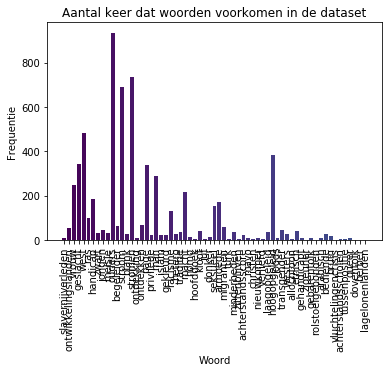

In [22]:
# leuk grafiekje van hoe vaak woorden voorkomen
# cute little graph of how often words occur
word_freq = {}

for woord in dataset_zoek['word']:
    # als woord in de aanwezige dictionary staat, dan voeg je één waarde toe
    # if word already in dict of present words, add one to the total
    if woord in word_freq:
        word_freq[woord] += 1
    # negeer NaNs
    # ignore NaNs
    elif pd.isna(woord) == True:
        pass
    # als het woord nog niet in de dictionary staat, voeg het dan toe
    # if word is not yet in the dict, add it
    else:
        word_freq[woord] = 1
        
mycmap = plt.get_cmap("viridis").colors

# plotten
# plotting
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de dataset')
plt.show()

In [9]:
# laten we kijken naar zinnen met een specifiek zoekwoord
# let's look at some sentences with a specific search word
def vind_zinnen(woord):
    for i in range(len(dataset_zoek)):
        if dataset_zoek['word'].iloc[i] == woord:
            print(dataset_zoek['text'].iloc[i])
            print("DOCUMENT:")
            print(dataset_zoek['Onderwerp'].iloc[i])
            
vind_zinnen('etnisch')

     Niet iedereen       en alles in de FSV is <mark style="background: #00ced1!important">etnisch</mark>       geprofileerd    en  discriminerend
     van   aard. Maar omdat        bij FSV-registraties      niet kan worden      uitgesloten dat
     dit omwille      van   etniciteit, persoonskenmerken,           nationaliteit of  leeftijd is
     gebeurd, betekent dit dat er sprake is van een stelselmatige (over)controle
     van   bepaalde bevolkingsgroepen, terwijl anderen buiten beeld kunnen blijven.
     Het is dus     goed te begrijpen dat het kabinet erkent dat in deze werkprocessen
     sprake     is van  ‘institutioneel racisme’. Voor een groep van bijna 900 mensen
     waren     de  gevolgen van hun registratie in de FSV bovendien nog veel groter:”
     zij kwamen       bijvoorbeeld niet in aanmerking voor betalingsregelingen of
     schuldsanering, met verstrekkende financiéle gevolgen die anno 2024 nog
     steeds niet volledig in beeld zijn. De FSV is dus een praktijk van i

In [37]:
# testdocument: Rapportage fase 1 dialoog SamenSpraak
# test file: Rapportage fase 1 dialoog SamenSpraak

# dit document splitsen in zinnen en beschikbaar maken voor labelling
# split document in sentences and make available for labelling

# als de data wordt aangeleverd in paragraafformat
# if data gets provided in paragraph format
def generate_to_label_paragrafen(dataset, document = 'all'):
    if document == 'all':
        kolommen = ['document', 'text', 'zin']
        data = []
        paragrafen = []
        woorden = []

        # split zinnen op aanwezigheid van '.', '!' of '?'
        # isolate sentences based on '.' or '!' or '?'
        for i in range(len(dataset_zoek)):
            # voorkomen dat paragrafen dubbel worden opgenomen
            # prevent paragraphs from being included more than once
            paragraaf = dataset['text'].iloc[i]
            document = dataset['Onderwerp'].iloc[i]
            if paragraaf not in paragrafen:
                paragrafen.append(paragraaf)
                zinnen = paragraaf.split(sep = '.')

                for zin in zinnen:
                    data.append([document, paragraaf, zin])
        to_label = pd.DataFrame(data, columns = kolommen)
        return(to_label)
    
    else: #filter specifiek document / filter for specific document
        kolommen = ['document', 'text', 'zin']
        data = []
        paragrafen = []
        woorden = []

        # isolate sentences based on '.' or '!' or '?'
        for i in range(len(dataset)):
            if dataset['Onderwerp'].iloc[i] == document:
                # voorkomen dat paragrafen dubbel worden opgenomen
                # prevent paragraphs from being included more than once
                paragraaf = dataset['text'].iloc[i]
                document = dataset['Onderwerp'].iloc[i]
                if paragraaf not in paragrafen:
                    paragrafen.append(paragraaf)
                    zinnen = paragraaf.split(sep = '.')

                    for zin in zinnen:
                        data.append([document, paragraaf, zin])
        to_label = pd.DataFrame(data, columns = kolommen)
        return(to_label)

# als de data al is gesplitst in zinnen
# if data has already been split into sentences
def generate_to_label_zinnen(dataset, document = 'all'):
    if document == 'all':
        kolommen = ['id', 'document', 'text', 'zin']
        data = []
        paragrafen = []
        woorden = []

        # # split zinnen op aanwezigheid van '.', '!' of '?'
        # isolate sentences based on '.' or '!' or '?'
        for i in range(len(dataset_zoek)):
            # voorkomen dat paragrafen dubbel worden opgenomen
            # prevent paragraphs from being included more than once
            zin_id = str(dataset_zoek['Id'].iloc[i]) + '_' + str(dataset_zoek['pagina'].iloc[i]) + '_' + str(dataset_zoek['Id_hoofddocument'].iloc[i])
            zin = str(dataset_zoek['text'].iloc[i])
            document = dataset_zoek['Onderwerp'].iloc[i]

            # voeg voorgaande en opvolgende zin toe om context mee te geven
            # add previous and next sentence to add context
            if i == 0:
                paragraaf = str(dataset_zoek['text'].iloc[i]) + str(dataset_zoek['text'].iloc[i+1])
            elif i == len(dataset_zoek)-1:
                paragraaf = str(dataset_zoek['text'].iloc[i-1]) + str(dataset_zoek['text'].iloc[i])
            else:
                paragraaf = str(dataset_zoek['text'].iloc[i-1]) + str(dataset_zoek['text'].iloc[i]) + str(dataset_zoek['text'].iloc[i+1])
            data.append([zin_id, document, paragraaf, zin])
        to_label = pd.DataFrame(data, columns = kolommen)
        return(to_label)
    else:
        kolommen = ['id', 'document', 'text', 'zin']
        data = []
        paragrafen = []
        woorden = []

        # zinnen zijn al geïsoleerd
        # if sentences have already been split
        for i in range(len(dataset_zoek)):
            if dataset_zoek['Onderwerp'].iloc[i] == document:
                # voorkomen dat paragrafen dubbel worden opgenomen
                # prevent paragraphs from being added more than once
                zin_id = str(dataset_zoek['Id'].iloc[i]) + '_' + str(dataset_zoek['pagina'].iloc[i]) + '_' + str(dataset_zoek['Id_hoofddocument'].iloc[i])
                zin = dataset_zoek['text'].iloc[i]
                document = dataset_zoek['Onderwerp'].iloc[i]

                # voeg voorgaande en opvolgende zin toe om context mee te geven
                # prevent paragraphs from being included more than once
                if i == 0:
                    paragraaf = dataset_zoek['text'].iloc[i] + dataset_zoek['text'].iloc[i+1]
                elif i == len(dataset_zoek)-1:
                    paragraaf = dataset_zoek['text'].iloc[i-1] + dataset_zoek['text'].iloc[i]
                else:
                    paragraaf = dataset_zoek['text'].iloc[i-1] + dataset_zoek['text'].iloc[i] + dataset_zoek['text'].iloc[i+1]
                data.append([zin_id, document, paragraaf, zin])
        to_label = pd.DataFrame(data, columns = kolommen)
        return(to_label)
    
data_for_labelling = generate_to_label_zinnen(dataset_zoek)

# dummy: voeg synthetische score annotator + uiteindelijk voorspeld label toe
# for dummy data: add a synthetic score of annotators and a synthetic predicted label
def dummy_scores(dataset, dummy = False):
    if dummy == True:
        for i in range(len(dataset)):
            print(i)
            score = random.rand()
            dataset['score_annotator'].iloc[i] = score
            dataset['totaalscore'].iloc[i] = np.round(score)
    else:
        data_for_labelling['score'] = ''
    return dataset
            
data_for_labelling = dummy_scores(data_for_labelling, dummy = False)

display(data_for_labelling)

,id,document,text,zin,score
0,d4cfb963-de8d-400e-bb87-5493b794a255_1_4adc737...,Beslisnota bij Kamerbrief over Geografische Ba...,...,...,
1,d4cfb963-de8d-400e-bb87-5493b794a255_2_4adc737...,Beslisnota bij Kamerbrief over Geografische Ba...,...,Onze referentie\nVerdel...,
2,7eb69333-4557-4594-b5be-1276e3c0f2da_2_027bdd4...,Kwartaalrapportage Q4 2023,Onze referentie\nVerdel...,"groeifaciliteit voor de 23987, nr. aanspraa...",
3,ad741e24-86a7-47a2-ad12-fbde149fe4bc_8_e4269c3...,Advies GR; Verbetermogelijkheden voor het bevo...,"groeifaciliteit voor de 23987, nr. aanspraa...",hoofdstuk 01 | Inleiding ...,
4,ad741e24-86a7-47a2-ad12-fbde149fe4bc_17_e4269c...,Advies GR; Verbetermogelijkheden voor het bevo...,hoofdstuk 01 | Inleiding ...,"hoofdstuk 03 | Effectiviteit, resultaten, nade...",
...,...,...,...,...,...
6328,490faff2-b50c-4a78-afdc-f36ed34ed3df_10_039b80...,"Quick scan Financiële impact maatregelen ""Voor...",QUICK SCAN D.D...,QUICK SCAN D....,
6329,490faff2-b50c-4a78-afdc-f36ed34ed3df_11_039b80...,"Quick scan Financiële impact maatregelen ""Voor...",QUICK SCAN D....,QUICK SCAN...,
6330,490faff2-b50c-4a78-afdc-f36ed34ed3df_15_039b80...,"Quick scan Financiële impact maatregelen ""Voor...",QUICK SCAN...,QUICK SCA...,
6331,490faff2-b50c-4a78-afdc-f36ed34ed3df_16_039b80...,"Quick scan Financiële impact maatregelen ""Voor...",QUICK SCA...,QUICK...,


In [25]:
# voeg een sentiment analysis feature toe
# add a sentiment analysis feature
pipe = pipeline("text-classification", model="wietsedv/bert-base-dutch-cased-finetuned-sentiment", return_all_scores=True)

negatives = 0
positives = 0
neutrals = 0

# vind of het label positief, negatief of neutraal is
# find if the sentiment is negative, positive or neutral
for i in range(len(data_for_labelling)):
    label = pipe(data_for_labelling.loc[i, 'zin'], truncation = True)
    neg_label = label[0][0]['score']
    pos_label = label[0][1]['score']
    if neg_label > pos_label:
        data_for_labelling['label'] = 'negatief'
        negatives += 1
    elif neg_label < pos_label:
        data_for_labelling['label'] = 'positief'
        positives +=1
    else:
        data_for_labelling['label'] = 'neutraal'
        neutrals += 1

# printen hoe vaak ieder label voorkomt
# print how often each label occurs
print(positives, negatives, neutrals)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│ /data/milenadeswart/.local/lib/python3.7/site-packages/transformers/pipelines/text_classificatio │
│ n.py:155 in __call__                                                                             │
│                                                                                                  │
│   152 │   │   │                                                                                  │
│   153 │   │   │   If `top_k` is used, one such dictionary is returned per label.                 │
│   154 │   │   """                                                                                │
│ ❱ 155 │   │   result = super().__call__(*args, **kwargs)                                         │
│   156 │   │   # TODO try and retrieve it in a nicer way from _sanitize_parameters.               │
│   157 │   │   _legacy = "top_k" not in kwargs                                                    │
│   158 │   │   if isinstance(args[0], str) and _legacy:                                           │
│                                                                                                  │
│ /data/milenadeswart/.local/lib/python3.7/site-packages/transformers/pipelines/base.py:1120 in    │
│ __call__                                                                                         │
│                                                                                                  │
│   1117 │   │   │   │   )                                                                         │
│   1118 │   │   │   )                                                                             │
│   1119 │   │   else:                                                                             │
│ ❱ 1120 │   │   │   return self.run_single(inputs, preprocess_params, forward_params, postproces  │
│   1121 │                                                                                         │
│   1122 │   def run_multi(self, inputs, preprocess_params, forward_params, postprocess_params):   │
│   1123 │   │   return [self.run_single(item, preprocess_params, forward_params, postprocess_par  │
│                                                                                                  │
│ /data/milenadeswart/.local/lib/python3.7/site-packages/transformers/pipelines/base.py:1127 in    │
│ run_single                                                                                       │
│                                                                                                  │
│   1124 │                                                                                         │
│   1125 │   def run_single(self, inputs, preprocess_params, forward_params, postprocess_params):  │
│   1126 │   │   model_inputs = self.preprocess(inputs, **preprocess_params)                       │
│ ❱ 1127 │   │   model_outputs = self.forward(model_inputs, **forward_params)                      │
│   1128 │   │   outputs = self.postprocess(model_outputs, **postprocess_params)                   │
│   1129 │   │   return outputs                                                                    │
│   1130                                                                                           │
│                                                                                                  │
│ /data/milenadeswart/.local/lib/python3.7/site-packages/transformers/pipelines/base.py:1026 in    │
│ forward                                                                                          │
│                                                                                                  │
│   1023 │   │   │   │   inference_context = self.get_inferen

In [38]:
# optioneel: exporteer naar .csv
# optional: export to .csv
export_path = 'milenadeswart/share/Milena/programma-discriminatie-en-racisme/datasets/'
data_for_labelling.to_csv('dataset_dummy_empty.csv', sep = ';')